Best Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Best CV Accuracy: 92.27%
KNN Evaluation Metrics:
      Metric     Score
0   Accuracy   97.3000
1  Precision  100.0000
2     Recall   94.5900
3   F1 Score   97.2200
4        MCC   94.7331


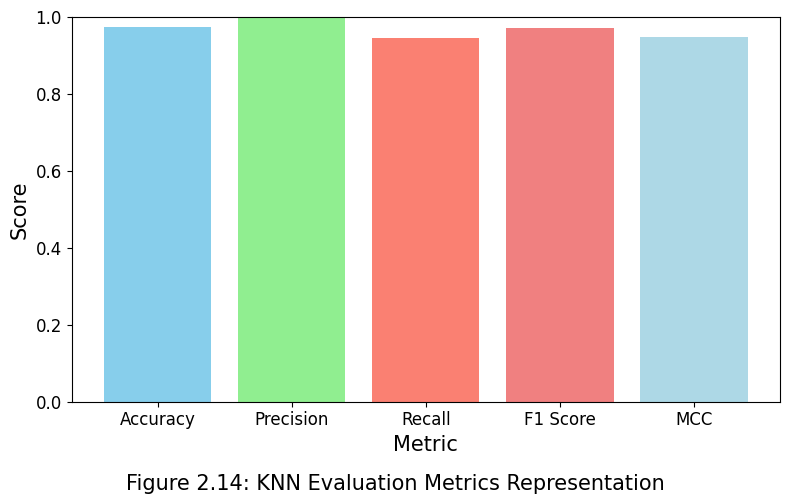

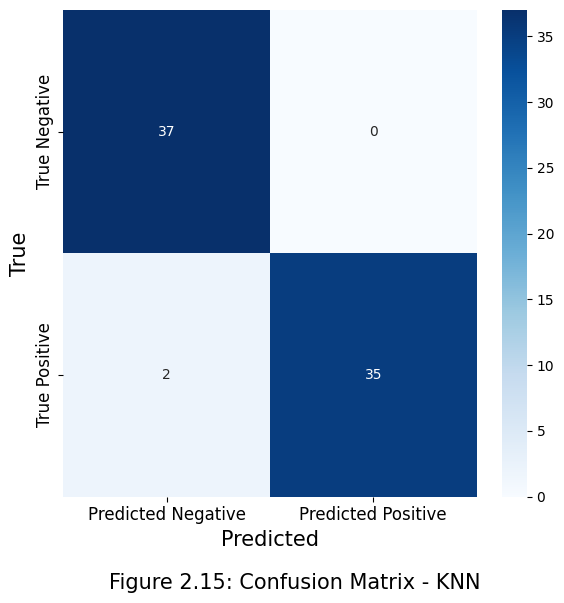

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # Add this import

# 1. Load dataset from UCI
url_string = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
url_content = requests.get(url_string).content
with open('data.csv', 'wb') as data_file:
    data_file.write(url_content)

df = pd.read_csv('data.csv')

# 2. Preprocess
X = df.drop(['name', 'status'], axis=1)
y = df['status']

# Scaling before SMOTE
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE (Apply after scaling)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled
)

# 4. GridSearchCV to find best 'k' (number of neighbors)
param_grid = {
    'n_neighbors': list(range(4, 21)),  # Try K from 4 to 20
    'weights': ['uniform', 'distance'],  # Try both weighting strategies
    'metric': ['euclidean']  # Optional: can try others like 'manhattan' too
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

# 5. Best parameters
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy: {:.2f}%".format(grid.best_score_ * 100))

# 6. Evaluate on the test set using best estimator
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
mcc = matthews_corrcoef(y_test, y_pred)

# Store results in DataFrame
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC'],
    'Score': [round(accuracy * 100, 2), round(precision * 100, 2),
              round(recall * 100, 2), round(f1 * 100, 2), round(mcc * 100, 4)]
})

# Print performance table
print("KNN Evaluation Metrics:")
print(results)

# Bar Chart for performance metrics
plt.figure(figsize=(8, 5))
scores = results['Score'].values / 100  # Convert to 0-1 scale for plotting
plt.bar(results['Metric'], scores,
        color=['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'lightblue'])

# plt.title('KNN Evaluation Metrics Representation')
plt.xlabel('Metric', fontsize=15, color='black')
plt.ylabel('Score', fontsize=15,color='black')

plt.ylim(0, 1)
plt.tick_params(axis='both', colors='black', labelsize=12)
plt.figtext(0.5, 0.01, 'Figure 2.14: KNN Evaluation Metrics Representation',
            wrap=True, horizontalalignment='center', fontsize=15)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('knn_metrics.png', dpi=300)
plt.show()

# 7. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted', fontsize=15, fontname='Times New Roman', color='black')
plt.ylabel('True', fontsize=15, fontname='Times New Roman', color='black')
plt.tick_params(axis='both', colors='black', labelsize=12)
# plt.title('Confusion Matrix - Random Forest')

plt.figtext(0.5, 0.01, 'Figure 2.15: Confusion Matrix - KNN',
            wrap=True, horizontalalignment='center', fontsize=15)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('confusion_matrix_knn.png', dpi=300)
plt.show()
